# Step 1: Data processing and aggregating

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = pd.read_excel('Asssignment 2 - Python.xlsx')

#'Unnamed: 0' column is unncessary, removing this column
data_cleaned = data.drop(columns=['Unnamed: 0'])

# Missing value check
missing_values = data_cleaned.isnull().sum()
data_types = data_cleaned.dtypes
missing_values, data_types

(Week Start Dates                0
 Sales (USD)                     0
 TV_Spend (USD)                  0
 TV_GRP (Points)                 0
 Digital_Spend (USD)             0
 Digital_Impressions (Points)    0
 Print_Spend (USD)               0
 Print_Circulation (Points)      0
 dtype: int64,
 Week Start Dates                 object
 Sales (USD)                     float64
 TV_Spend (USD)                  float64
 TV_GRP (Points)                 float64
 Digital_Spend (USD)             float64
 Digital_Impressions (Points)    float64
 Print_Spend (USD)               float64
 Print_Circulation (Points)      float64
 dtype: object)

In [18]:
# Aggregate week-level data to month-level data
data_cleaned['Week Start Dates'] = pd.to_datetime(data_cleaned['Week Start Dates'])
data_cleaned['Month'] = data_cleaned['Week Start Dates'].dt.to_period('M')
monthly_data = data_cleaned.groupby('Month').sum(numeric_only=True).reset_index()
monthly_data.head(), monthly_data.tail()


(     Month    Sales (USD)  TV_Spend (USD)  TV_GRP (Points)  \
 0  2018-12   53573.702072      962.162019        41.449884   
 1  2019-01  319947.799150     2950.995458       100.794842   
 2  2019-02  163085.299152     2513.391454       160.924993   
 3  2019-03  368780.260179     2835.112423       253.423783   
 4  2019-04  218821.330885     2118.559186       233.618306   
 
    Digital_Spend (USD)  Digital_Impressions (Points)  Print_Spend (USD)  \
 0          6528.933475                  74779.393510          74.274173   
 1         36282.966370                 324847.307144         389.075222   
 2         15211.983559                 199034.683067         156.494188   
 3         33517.604298                 269850.782229         296.827140   
 4         19369.813116                 260413.158529         266.954353   
 
    Print_Circulation (Points)  
 0                   73.089147  
 1                  196.805891  
 2                  243.161620  
 3                  316.510807

# Step 2: Define Transformation Functions

transform_ads: y (t) = x (t) + ret * y (t-1)

transform_sat: y (t) = x (t) * [x (t) ^ alpha] / [x (t) ^ alpha + gamma ^ alpha]

transform_lag: y (t) = x (t - lag)

In [20]:
#Transformation functions
def transform_ads(x, ret=0.6):
    y = np.zeros_like(x)
    y[0] = x[0]
    for t in range(1, len(x)):
        y[t] = x[t] + ret * y[t-1]
    return y

def transform_sat(x, alpha=3, gamma=None):
    y = np.zeros_like(x)
    for t in range(len(x)):
        y[t] = x[t] * (x[t] ** alpha) / (x[t] ** alpha + gamma ** alpha)
    return y

def transform_lag(x, lag=2):
    y = np.zeros_like(x)
    for t in range(lag, len(x)):
        y[t] = x[t-lag]
    return y

# Step 3: Apply transformations

Reference Values: ret: 0.6

alpha: 3

gamma: 0.6 X sum(ads_transformed column)

for the respective media; lag: 2

In [21]:
# Apply transformations to media channel points
for channel in ['TV_GRP (Points)', 'Digital_Impressions (Points)', 'Print_Circulation (Points)']:
    monthly_data[f'{channel}_ads'] = transform_ads(monthly_data[channel].values)
    gamma = 0.6 * monthly_data[f'{channel}_ads'].sum()
    monthly_data[f'{channel}_sat'] = transform_sat(monthly_data[f'{channel}_ads'].values, gamma=gamma)
    monthly_data[f'{channel}_lag'] = transform_lag(monthly_data[f'{channel}_sat'].values)

# Step 4: Perform correlation

In [22]:
# Calculate correlations with sales
correlations = {}
for col in ['TV_Spend (USD)', 'Digital_Spend (USD)', 'Print_Spend (USD)', 
            'TV_GRP (Points)_ads', 'Digital_Impressions (Points)_ads', 'Print_Circulation (Points)_ads']:
    correlations[col] = monthly_data['Sales (USD)'].corr(monthly_data[col])

In [23]:
correlations

{'TV_Spend (USD)': 0.5935761084808746,
 'Digital_Spend (USD)': 0.7892656413725456,
 'Print_Spend (USD)': 0.6429163479287164,
 'TV_GRP (Points)_ads': 0.3649195042591555,
 'Digital_Impressions (Points)_ads': 0.5894868033223828,
 'Print_Circulation (Points)_ads': 0.57455295125818}

# Step 5: Plot the Charts

# Bar chart

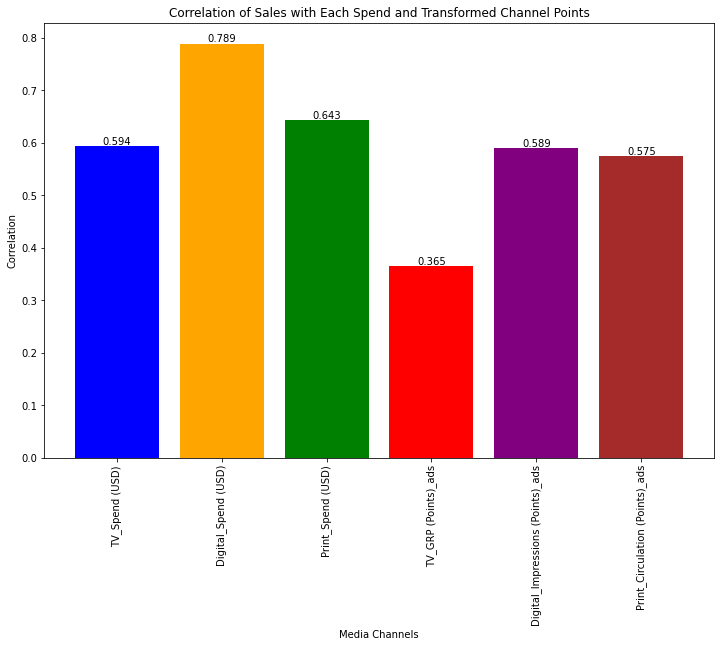

In [24]:
plt.figure(figsize=(12, 8))
bars = plt.bar(correlations.keys(), correlations.values(), color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.title('Correlation of Sales with Each Spend and Transformed Channel Points')
plt.xlabel('Media Channels')
plt.ylabel('Correlation')
plt.xticks(rotation=90)

# Add correlation values on bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/3, yval, round(yval,3), va='bottom')  # va: vertical alignment

plt.show()

# Combo line chart

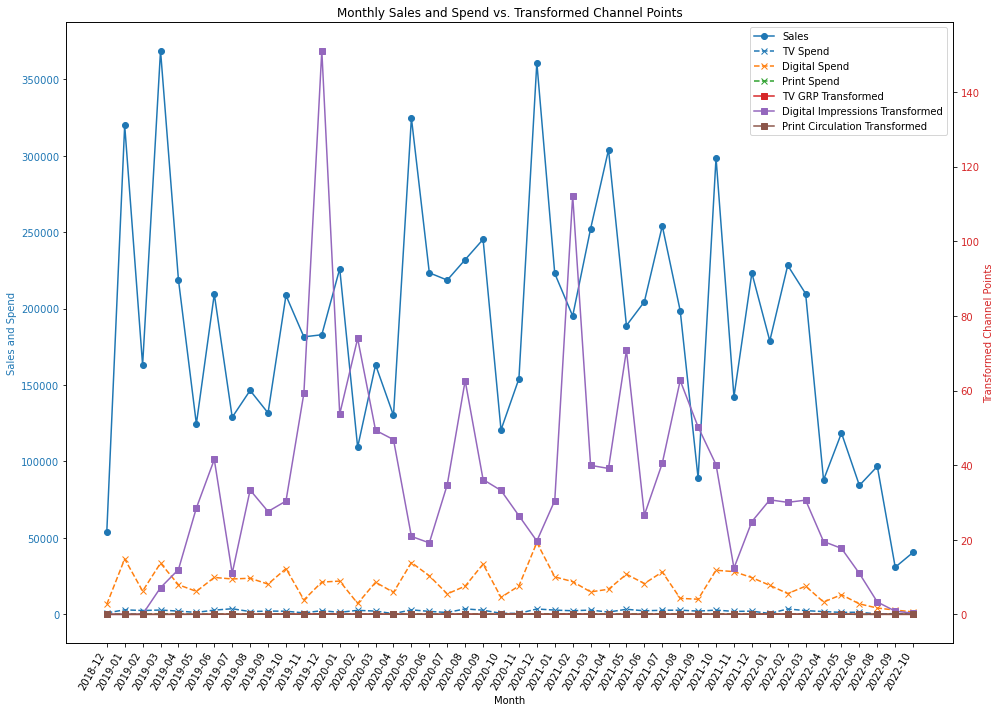

In [25]:
fig, ax1 = plt.subplots(figsize=(14, 10))

# Plot Sales and Spend on primary y-axis
ax1.set_xlabel('Month')
ax1.set_ylabel('Sales and Spend', color='tab:blue')
ax1.plot(monthly_data['Month'].astype(str), monthly_data['Sales (USD)'], label='Sales', color='tab:blue', marker='o')
ax1.plot(monthly_data['Month'].astype(str), monthly_data['TV_Spend (USD)'], label='TV Spend', linestyle='--', color='tab:blue', marker='x')
ax1.plot(monthly_data['Month'].astype(str), monthly_data['Digital_Spend (USD)'], label='Digital Spend', linestyle='--', color='tab:orange', marker='x')
ax1.plot(monthly_data['Month'].astype(str), monthly_data['Print_Spend (USD)'], label='Print Spend', linestyle='--', color='tab:green', marker='x')
ax1.tick_params(axis='y', labelcolor='tab:blue')
plt.xticks(rotation=60, ha='right')

# Create a second y-axis for Transformed Channel Points
ax2 = ax1.twinx()
ax2.set_ylabel('Transformed Channel Points', color='tab:red')
ax2.plot(monthly_data['Month'].astype(str), monthly_data['TV_GRP (Points)_lag'], label='TV GRP Transformed', color='tab:red', marker='s')
ax2.plot(monthly_data['Month'].astype(str), monthly_data['Digital_Impressions (Points)_lag'], label='Digital Impressions Transformed', color='tab:purple', marker='s')
ax2.plot(monthly_data['Month'].astype(str), monthly_data['Print_Circulation (Points)_lag'], label='Print Circulation Transformed', color='tab:brown', marker='s')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.765,1))

plt.title('Monthly Sales and Spend vs. Transformed Channel Points')
fig.tight_layout()
plt.show()


# Scatter chart

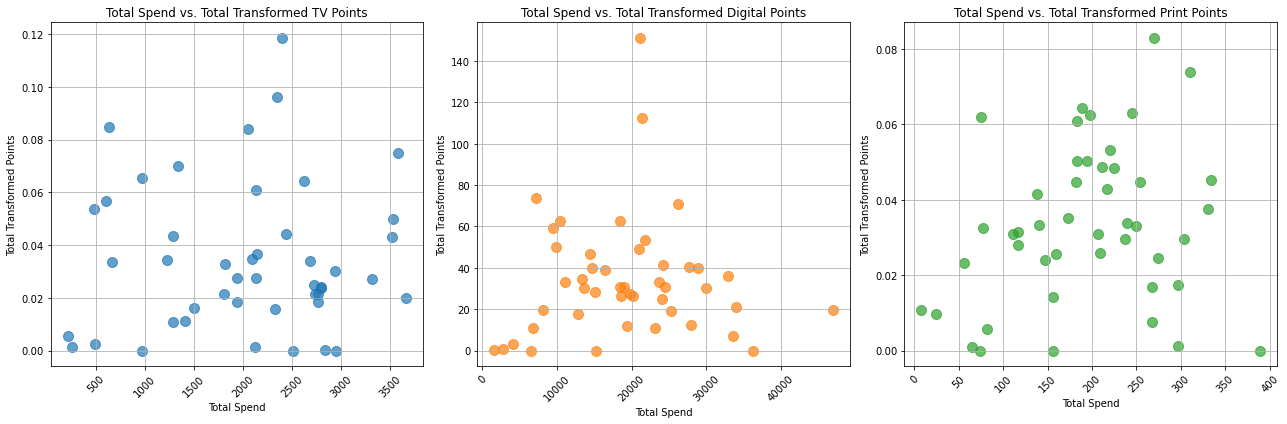

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
channels = ['TV', 'Digital', 'Print']
channel_transformed = ['TV_GRP (Points)', 'Digital_Impressions (Points)', 'Print_Circulation (Points)']
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, channel in enumerate(channels):
    axs[i].scatter(monthly_data[f'{channel}_Spend (USD)'], monthly_data[f'{channel_transformed[i]}_lag'], color=colors[i], s=100, alpha=0.7)
    axs[i].set_title(f'Total Spend vs. Total Transformed {channel} Points')
    axs[i].set_xlabel('Total Spend')
    axs[i].set_ylabel('Total Transformed Points')
    axs[i].grid(True)
    axs[i].tick_params(axis='x', rotation=45)

fig.tight_layout()
plt.show()

Digital_Spend (USD)
highest correlation with sales (0.789). This suggests that spending money on digital advertisements is most strongly associated with higher sales.

Print_Spend (USD)
second-highest correlation with sales (0.643). Print advertising also has a significant positive impact on sales, although not as strong as digital advertising. Increasing print ad spend can also be beneficial, but to a lesser extent than digital.

TV_Spend (USD)
correlation of 0.594 with sales. This indicates that TV advertising has a positive impact on sales, but its effectiveness is lower compared to digital and print advertising.


Transformed Channel Points:

Digital_Impressions (Points)_ads: 0.589

Print_Circulation (Points)_ads: 0.575

TV_GRP (Points)_ads: 0.365 These variables aslo showed a positive correlation with sales.
The data suggest that allocating more budget to Digital_Spend and Print_Spend will give best sales return.

To develop a strategy for maximizing sales return may consider giving weights the factors based on their correlation value with sales.